# **Convolutional Neural Networks and Computer Vision with TensorFlow**

So far we've covered the basics of TensorFlow and built a handful of models to work across different problems.

Now we're going to get specific and see how a special kind of neural network, **convolutional neural networks (CNNs)** can be used for computer vision (detecting patterns in visual data).


> 🔑 **Note**: In deep learning, many different kinds of model architectures can be used for different problems. For example, you could use a convolutional neural network for making predictions on image data and/or text data. However, in practice some architectures typically work better than others.



## **For example, you might want to**:

* Classify whether a picture of food contains pizza 🍕 or steak 🥩 (we're going to do this)
* Detect whether or not an object appears in an image (e.g. did a specific car pass through a security camera?)

In this notebook, we're going to follow the TensorFlow modelling workflow we've been following so far whilst learning about how to build and use **CNNs**.

## **What we're going to cover**
Specifically, we're going to go through the follow with TensorFlow:

* Getting a dataset to work with
* Architecture of a convolutional neural network
* A quick end-to-end example (what we're working towards)
* Steps in modelling for binary image classification with CNNs
* Becoming one with the data
* Preparing data for modelling
* Creating a CNN model (starting with a baseline)
* Fitting a model (getting it to find patterns in our data)
* Evaluating a model
* Improving a model
* Making a prediction with a trained model
* Steps in modelling for multi-class image classification with CNNs
* Same as above (but this time with a different dataset)

## **Get the data**


The images we're working with are from the Food101 dataset (101 different classes of food): https://www.kaggle.com/dansbecker/food-101

However we have modified it to only use two classes (pizza & steak).

In [2]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

# Unzip
zip_ref = zipfile.ZipFile("pizza_steak.zip")
zip_ref.extractall()
zip_ref.close()

--2024-08-01 02:32:18--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.207, 173.194.202.207, 173.194.203.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M   113MB/s    in 0.9s    

2024-08-01 02:32:19 (113 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



In [3]:
import os

# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("pizza_steak"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'pizza_steak'.
There are 2 directories and 0 images in 'pizza_steak/test'.
There are 0 directories and 250 images in 'pizza_steak/test/pizza'.
There are 0 directories and 250 images in 'pizza_steak/test/steak'.
There are 2 directories and 0 images in 'pizza_steak/train'.
There are 0 directories and 750 images in 'pizza_steak/train/pizza'.
There are 0 directories and 750 images in 'pizza_steak/train/steak'.


In [4]:
# Another way to find out how many images are in a file
num_steak_images_train = len(os.listdir("pizza_steak/train/steak"))
num_steak_images_train

750

To vizualise our images, first let's get the class names programmatically.

In [5]:
# Get the classnames
import pathlib
import numpy as np

data_dir = pathlib.Path("pizza_steak/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))

# Print them out
print(class_names)

['pizza' 'steak']


In [6]:
# Let's vizualise our images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  target_folder = target_dir + target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}")
  return img

Image shape: (384, 512, 3)


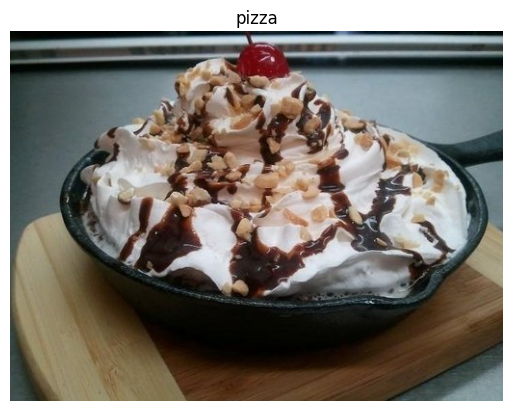

In [7]:
img = view_random_image(target_dir="pizza_steak/train/", target_class="pizza")

In [8]:
import tensorflow as tf
tf.constant(img)

<tf.Tensor: shape=(384, 512, 3), dtype=uint8, numpy=
array([[[  0,   9,   4],
        [  0,   8,   3],
        [  0,   7,   4],
        ...,
        [  0,   9,   4],
        [  1,  10,   5],
        [  2,  11,   6]],

       [[  2,   8,   4],
        [  1,   7,   3],
        [  1,   7,   3],
        ...,
        [  0,   9,   5],
        [  0,   8,   5],
        [  0,  10,   6]],

       [[  2,   7,   1],
        [  2,   7,   1],
        [  3,   8,   2],
        ...,
        [  0,  11,   9],
        [  0,   9,   8],
        [  0,  10,   8]],

       ...,

       [[ 59,  75,  72],
        [ 61,  77,  74],
        [ 63,  79,  78],
        ...,
        [131, 156, 160],
        [127, 152, 156],
        [125, 150, 154]],

       [[ 61,  77,  74],
        [ 61,  77,  74],
        [ 63,  79,  78],
        ...,
        [130, 155, 159],
        [127, 152, 156],
        [125, 150, 154]],

       [[ 63,  79,  76],
        [ 63,  79,  76],
        [ 62,  78,  77],
        ...,
        [130, 155, 15

In [9]:
# View the image shape
img.shape # returns width, height, color channels

(384, 512, 3)



> 🔑 **Note**: As we've discussed before, many machine learning models, including neural networks prefer the values they work with to be between 0 and 1. Knowing this, one of the most common preprocessing steps for working with images is to **scale** (also referred to as **normalize**) their pixel values by dividing the image arrays by 255. (since 255 is the maximum pixel value).



In [10]:
# Get all the pixel values b/w 0 & 1
img/255.

array([[[0.        , 0.03529412, 0.01568627],
        [0.        , 0.03137255, 0.01176471],
        [0.        , 0.02745098, 0.01568627],
        ...,
        [0.        , 0.03529412, 0.01568627],
        [0.00392157, 0.03921569, 0.01960784],
        [0.00784314, 0.04313725, 0.02352941]],

       [[0.00784314, 0.03137255, 0.01568627],
        [0.00392157, 0.02745098, 0.01176471],
        [0.00392157, 0.02745098, 0.01176471],
        ...,
        [0.        , 0.03529412, 0.01960784],
        [0.        , 0.03137255, 0.01960784],
        [0.        , 0.03921569, 0.02352941]],

       [[0.00784314, 0.02745098, 0.00392157],
        [0.00784314, 0.02745098, 0.00392157],
        [0.01176471, 0.03137255, 0.00784314],
        ...,
        [0.        , 0.04313725, 0.03529412],
        [0.        , 0.03529412, 0.03137255],
        [0.        , 0.03921569, 0.03137255]],

       ...,

       [[0.23137255, 0.29411765, 0.28235294],
        [0.23921569, 0.30196078, 0.29019608],
        [0.24705882, 0

## **An end to end example**

Let's build a convolutional neural network to find patterns in our images, more specifically we a need way to:

1. Load our images
2. Preprocess our images
3. Build a CNN to find patterns in our images
4. Compile our CNN
5. Fit the CNN to our training data

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import os

# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 0 & 1, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup paths to our data directories
train_dir = "/content/pizza_steak/train"
test_dir = "/content/pizza_steak/test"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)
valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

# Calculate steps per epoch
steps_per_epoch = len(train_data)
validation_steps = len(valid_data)

# Log dataset details
print(f"Training steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

# Build a CNN model (same as the Tiny VGG on the CNN explainer website)
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation="relu"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile our CNN
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


# Fit the model with verbose logging
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=steps_per_epoch,
                        validation_data=valid_data,
                        validation_steps=validation_steps,
                        verbose=2)  # Change verbose to 2 for more detailed logs


Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Training steps per epoch: 47
Validation steps: 16
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 - 18s - 393ms/step - accuracy: 0.6653 - loss: 0.6219 - val_accuracy: 0.7880 - val_loss: 0.4844
Epoch 2/5


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


AttributeError: 'NoneType' object has no attribute 'items'